In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from scipy import signal
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import seaborn as sb
import keras.backend as K
from tensorflow.keras.utils import plot_model
import pickle
import tqdm

In [4]:
data_dir = r'C:\Users\Teacher\My Drive\Colab Notebooks\MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main\MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

"""
- Participants num - 
sub1 ~ sub67

- Fall Types - 
FOL = Fall Foward from standing, use of hands to dampen fall
FKL = Fall Forward from standing, first impact on knees
BSC = Fall Backward while trying to sit on a chair
SDL = Fall Sidewards from standing, bending legs

- ADL Types -
STD = Standing with subtle movements
WAL = Normal Walking
JOG = Jogging
JUM = Continous jumping
STU = Stairs up(10 stairs)
STN = Stairs down(10 stairs)
SCH = Transition from standing to sitting
SIT = Sitting on chair with subtle movements
CHU = Transition from sitting to standing
CSI = Step in a car
CSO = Step out a car
LYI = Activity taken from the lying period after a fall

- 87 Hz mean sampling frequency for the accelerometer
- 200 Hz mean sampling rate for gyroscope and orientation data
"""
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
adl_types = ['STD', 'WAL', 'JOG', 'JUM', 'STU', 'STN', 'SCH', 'SIT', 'CHU', 'CSI', 'CSO', 'LYI']
person_numlist = list(range(1, 68))
trials = list(range(1, 4))

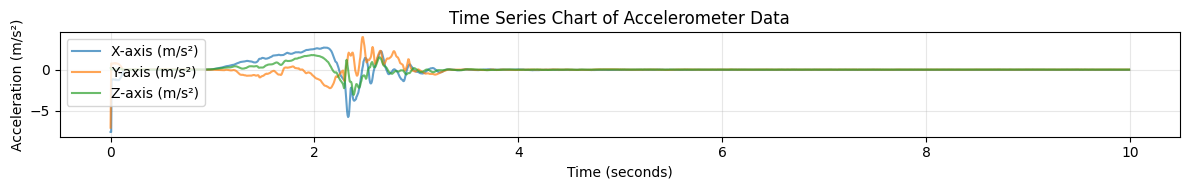

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/sub31/FALLS/BSC/BSC_gyro_31_1.txt'

# Reading the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Filtering and processing the data lines (ignore metadata and headers)
data_lines = []
for line in lines:
    line = line.strip()
    if line and not line.startswith("#") and not line.startswith("@"):
        data_lines.append(line.split(","))

# Converting the filtered data into a DataFrame
columns = ["timestamp(ns)", "x", "y", "z"]
df = pd.DataFrame(data_lines, columns=columns, dtype=float)

# Convert timestamp(ns) to seconds relative to the first timestamp
df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

# Plotting the time-series data
plt.figure(figsize=(12, 2))
plt.plot(df['time(s)'], df['x'], label="X-axis (m/s²)", alpha=0.7)
plt.plot(df['time(s)'], df['y'], label="Y-axis (m/s²)", alpha=0.7)
plt.plot(df['time(s)'], df['z'], label="Z-axis (m/s²)", alpha=0.7)
plt.title("Time Series Chart of Accelerometer Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


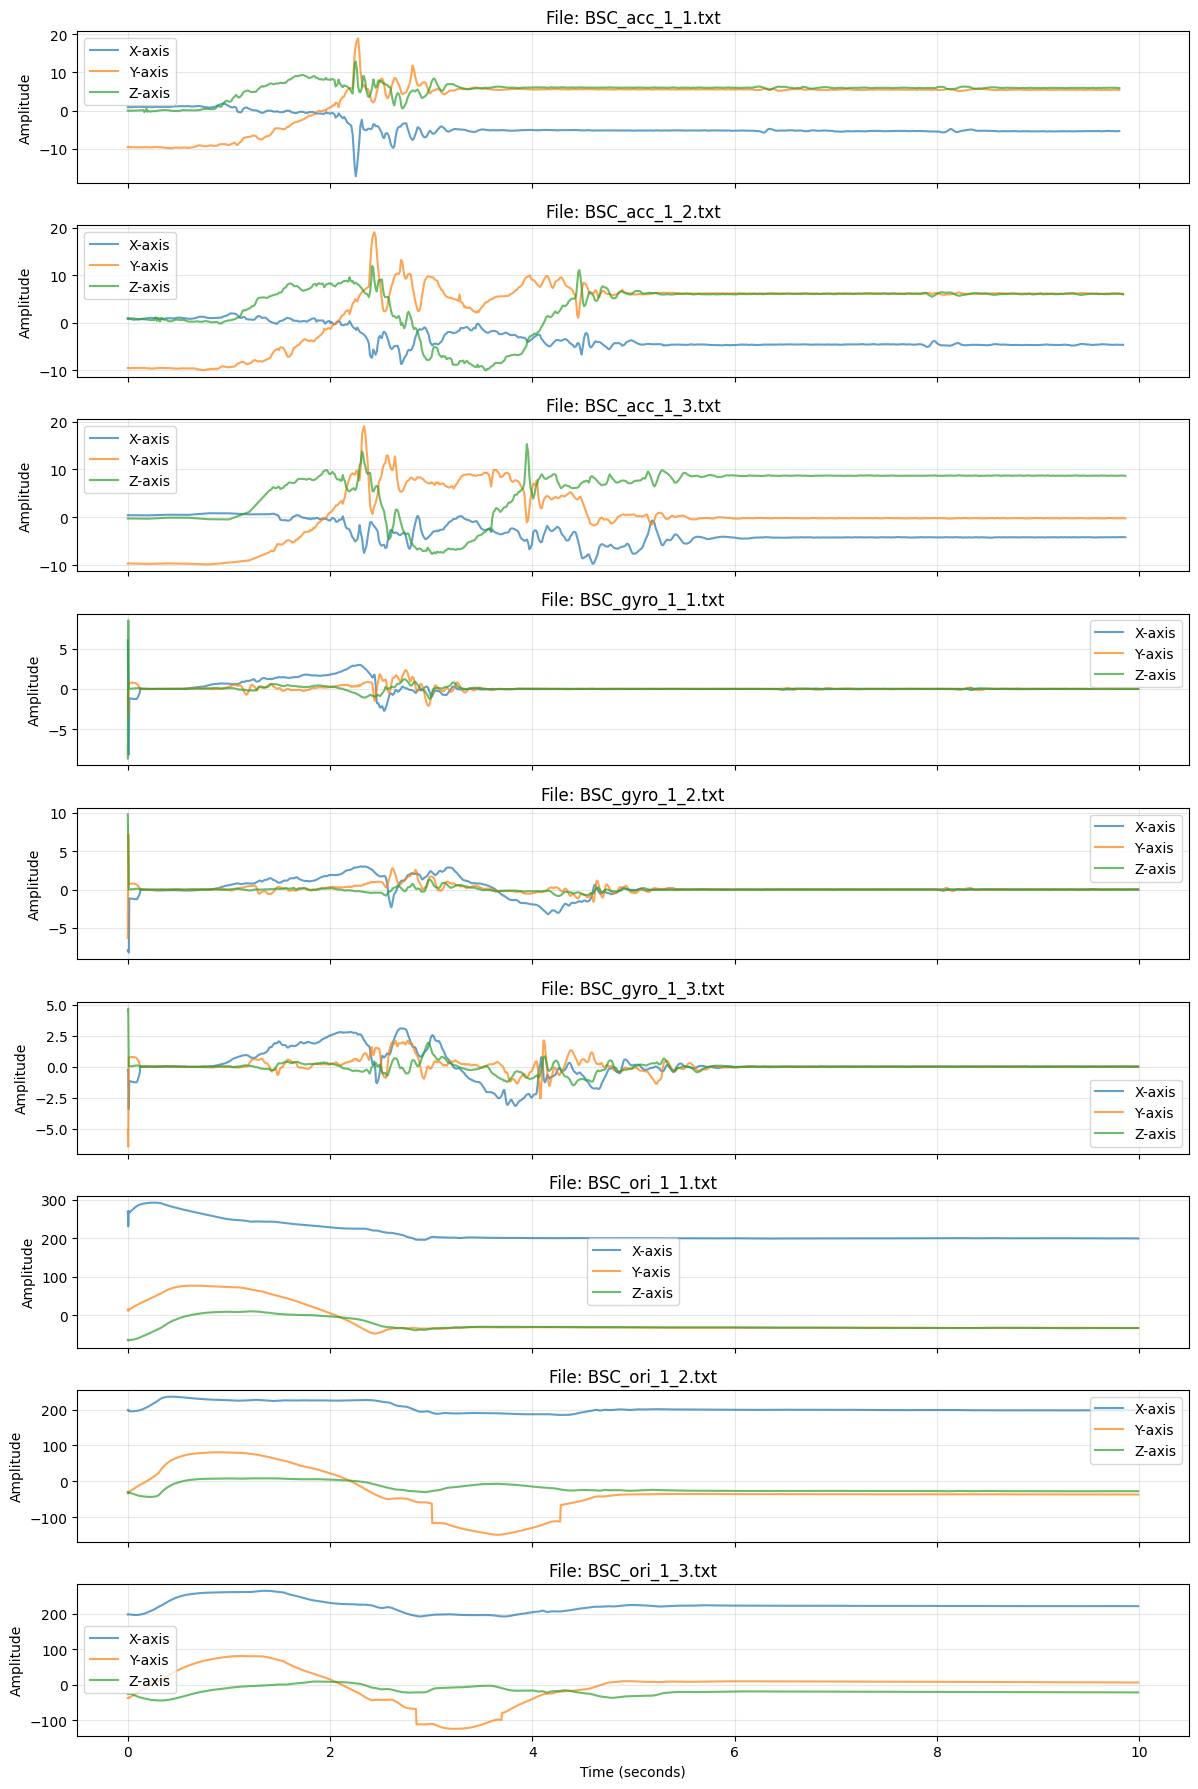

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

# Sub-directory for participant 1 falls - BSC
bsc_dir = os.path.join(base_dir, 'sub1', 'FALLS', 'BSC')

# Get all .txt files in the BSC directory
files = [f for f in os.listdir(bsc_dir) if f.endswith('.txt')]

# Create a subplot environment
num_files = len(files)
fig, axes = plt.subplots(num_files, 1, figsize=(12, 2 * num_files), sharex=True)

if num_files == 1:
    axes = [axes]  # To handle a single file case uniformly

for i, file in enumerate(files):
    # File path
    file_path = os.path.join(bsc_dir, file)
    
    # Reading the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Filtering and processing the data lines (ignore metadata and headers)
    data_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith("#") and not line.startswith("@"):
            data_lines.append(line.split(","))
    
    # Converting the filtered data into a DataFrame
    columns = ["timestamp(ns)", "x", "y", "z"]
    df = pd.DataFrame(data_lines, columns=columns, dtype=float)
    
    # Convert timestamp(ns) to seconds relative to the first timestamp
    df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

    # Plotting on the corresponding subplot
    axes[i].plot(df['time(s)'], df['x'], label="X-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['y'], label="Y-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['z'], label="Z-axis", alpha=0.7)
    axes[i].set_title(f"File: {file}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(alpha=0.3)
    if i == num_files - 1:  # Add xlabel only to the last subplot
        axes[i].set_xlabel("Time (seconds)")
    axes[i].legend()

plt.tight_layout()
plt.show()


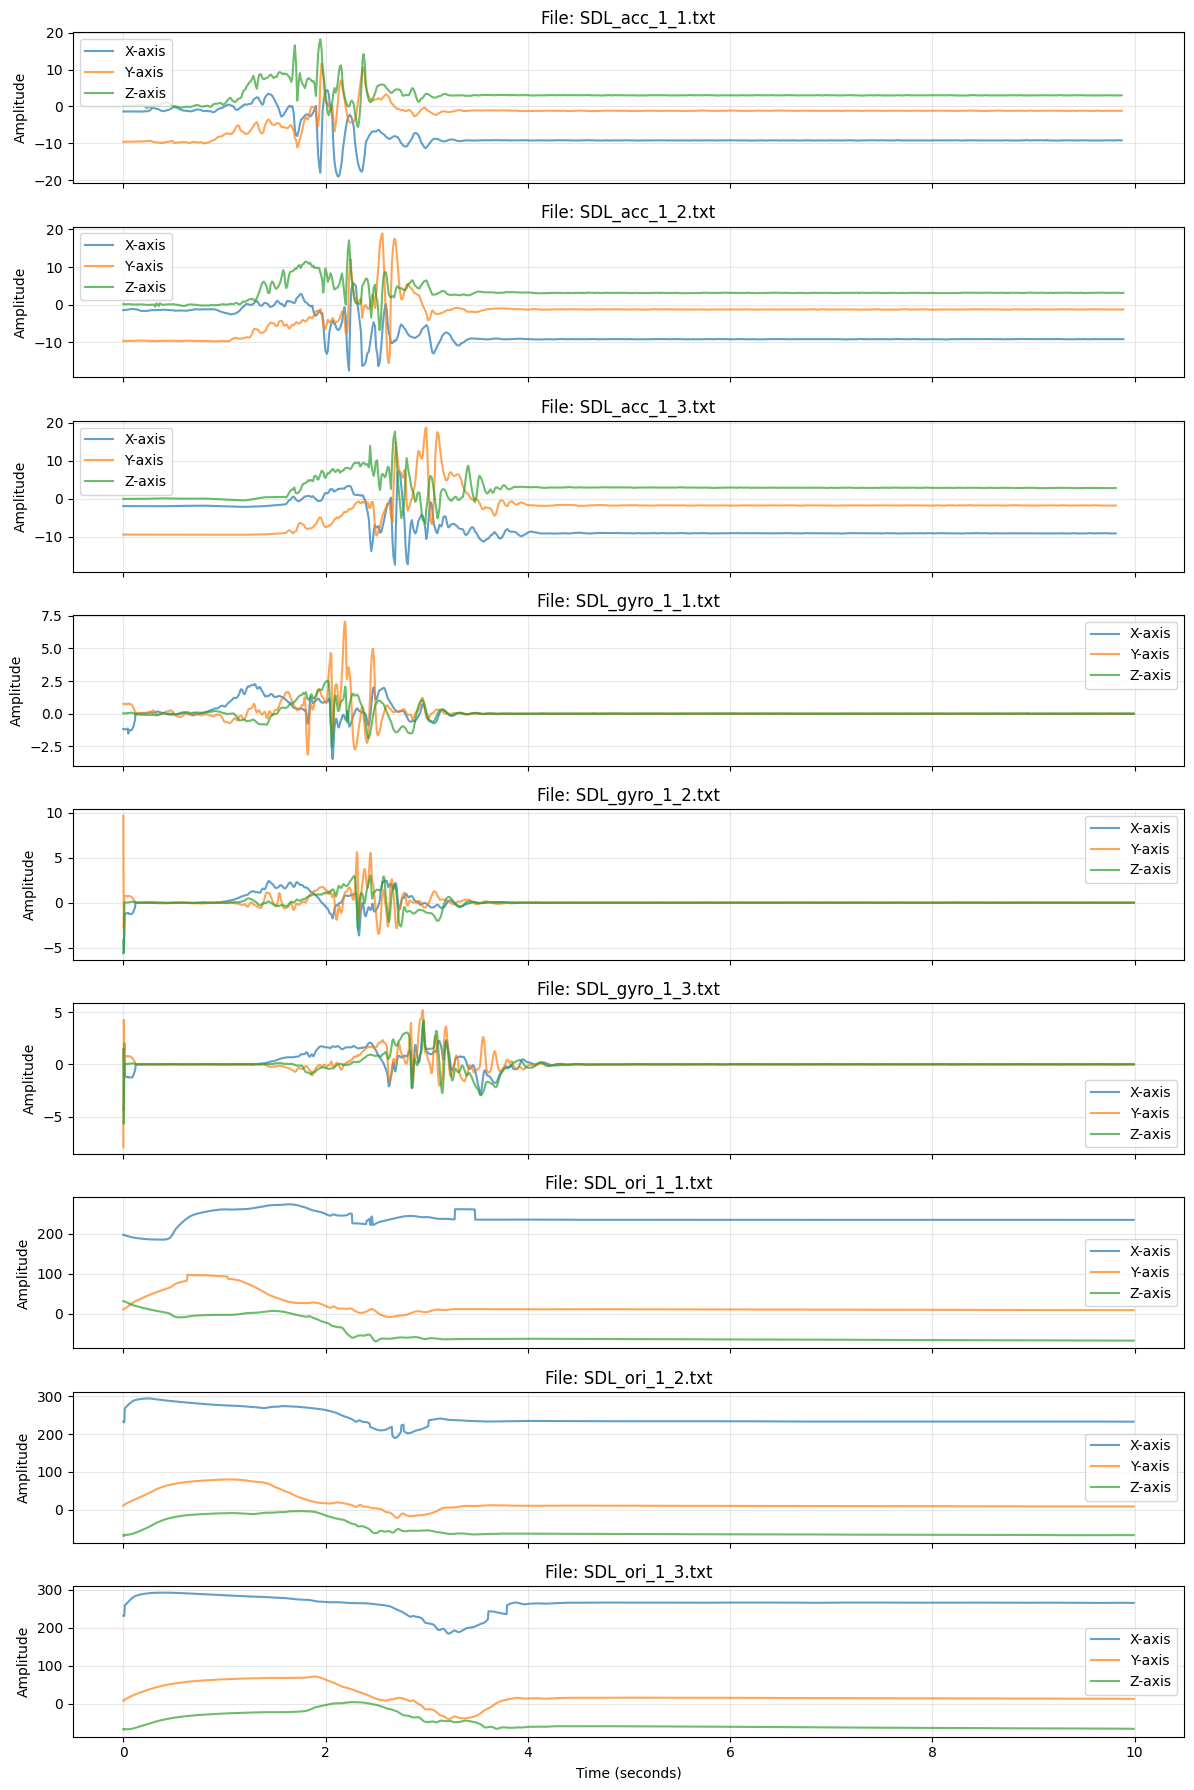

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

# Sub-directory for participant 1 falls - BSC
bsc_dir = os.path.join(base_dir, 'sub1', 'FALLS', 'SDL')

# Get all .txt files in the BSC directory
files = [f for f in os.listdir(bsc_dir) if f.endswith('.txt')]

# Create a subplot environment
num_files = len(files)
fig, axes = plt.subplots(num_files, 1, figsize=(12, 2 * num_files), sharex=True)

if num_files == 1:
    axes = [axes]  # To handle a single file case uniformly

for i, file in enumerate(files):
    # File path
    file_path = os.path.join(bsc_dir, file)
    
    # Reading the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Filtering and processing the data lines (ignore metadata and headers)
    data_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith("#") and not line.startswith("@"):
            data_lines.append(line.split(","))
    
    # Converting the filtered data into a DataFrame
    columns = ["timestamp(ns)", "x", "y", "z"]
    df = pd.DataFrame(data_lines, columns=columns, dtype=float)
    
    # Convert timestamp(ns) to seconds relative to the first timestamp
    df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

    # Plotting on the corresponding subplot
    axes[i].plot(df['time(s)'], df['x'], label="X-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['y'], label="Y-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['z'], label="Z-axis", alpha=0.7)
    axes[i].set_title(f"File: {file}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(alpha=0.3)
    if i == num_files - 1:  # Add xlabel only to the last subplot
        axes[i].set_xlabel("Time (seconds)")
    axes[i].legend()

plt.tight_layout()
plt.show()


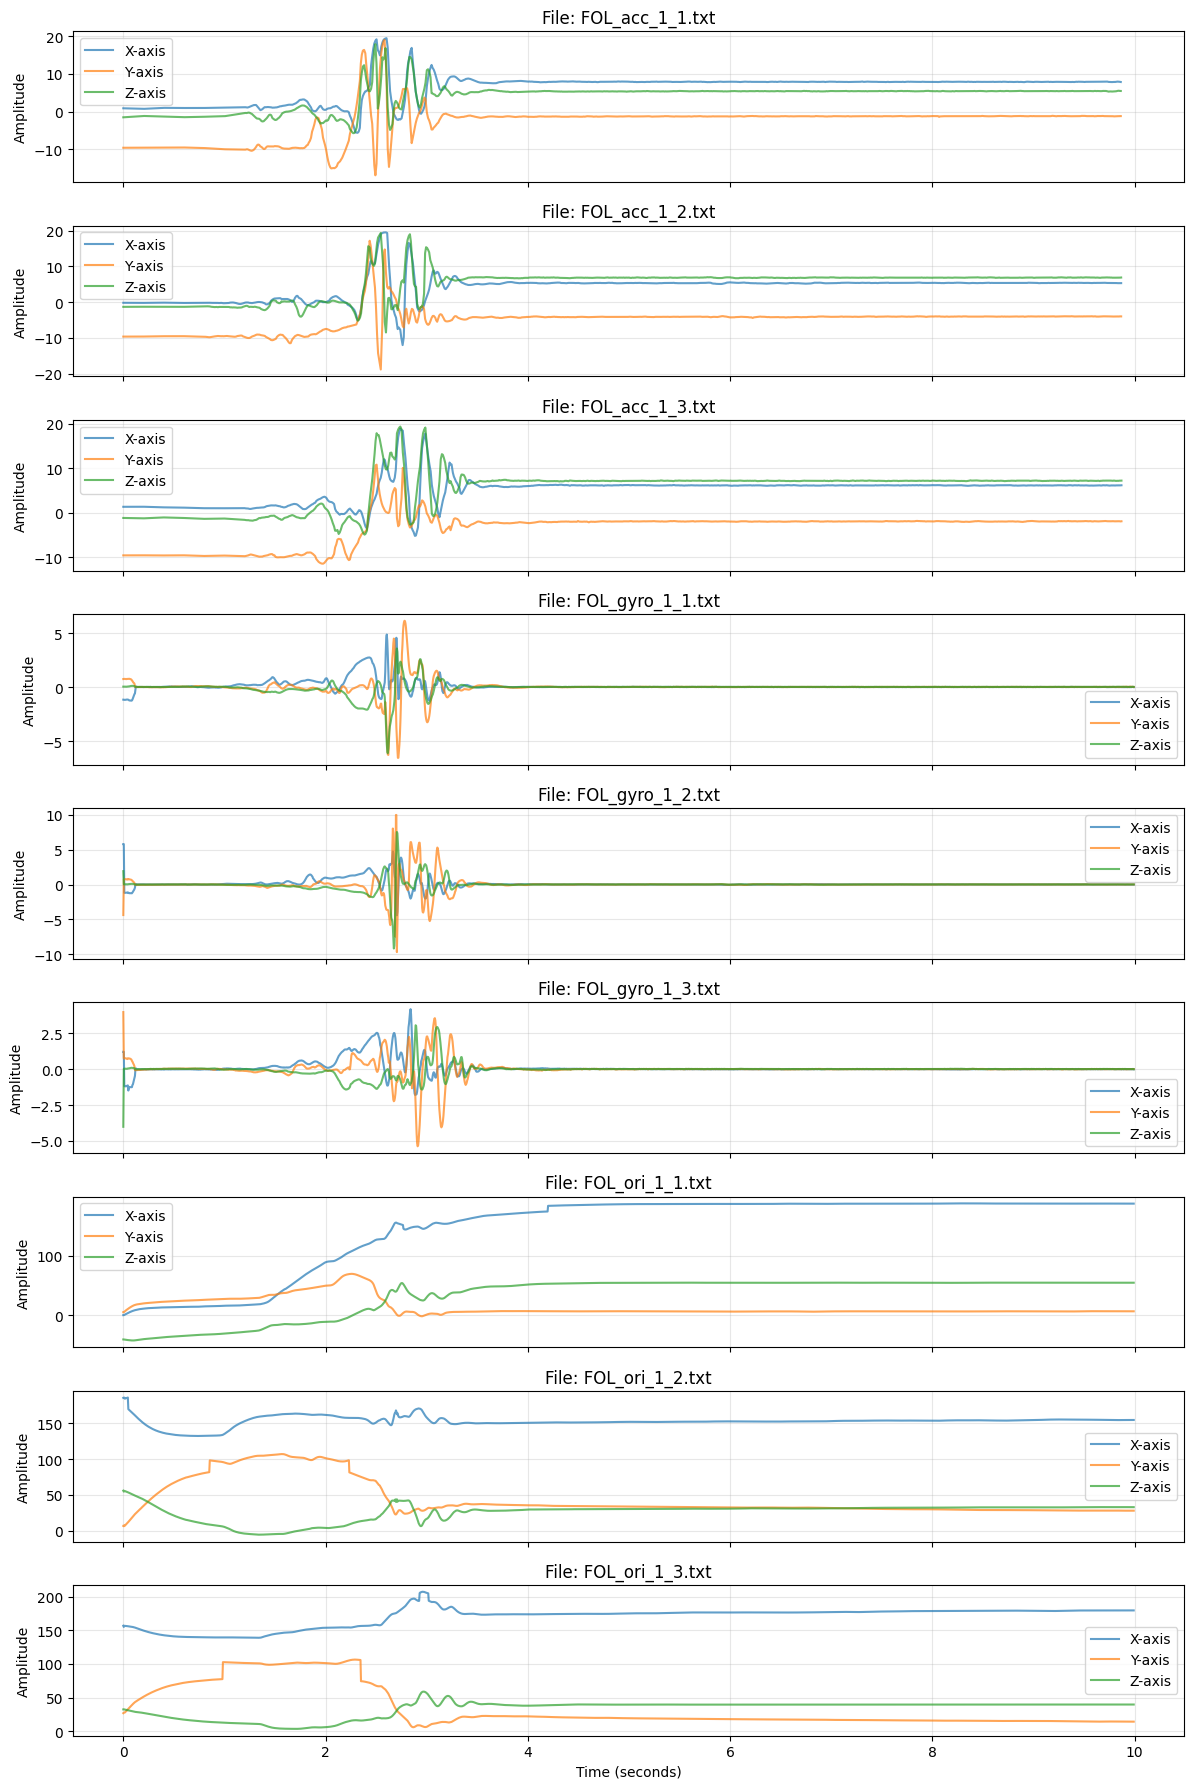

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

# Sub-directory for participant 1 falls - BSC
bsc_dir = os.path.join(base_dir, 'sub1', 'FALLS', 'FOL')

# Get all .txt files in the BSC directory
files = [f for f in os.listdir(bsc_dir) if f.endswith('.txt')]

# Create a subplot environment
num_files = len(files)
fig, axes = plt.subplots(num_files, 1, figsize=(12, 2 * num_files), sharex=True)

if num_files == 1:
    axes = [axes]  # To handle a single file case uniformly

for i, file in enumerate(files):
    # File path
    file_path = os.path.join(bsc_dir, file)
    
    # Reading the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Filtering and processing the data lines (ignore metadata and headers)
    data_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith("#") and not line.startswith("@"):
            data_lines.append(line.split(","))
    
    # Converting the filtered data into a DataFrame
    columns = ["timestamp(ns)", "x", "y", "z"]
    df = pd.DataFrame(data_lines, columns=columns, dtype=float)
    
    # Convert timestamp(ns) to seconds relative to the first timestamp
    df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

    # Plotting on the corresponding subplot
    axes[i].plot(df['time(s)'], df['x'], label="X-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['y'], label="Y-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['z'], label="Z-axis", alpha=0.7)
    axes[i].set_title(f"File: {file}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(alpha=0.3)
    if i == num_files - 1:  # Add xlabel only to the last subplot
        axes[i].set_xlabel("Time (seconds)")
    axes[i].legend()

plt.tight_layout()
plt.show()


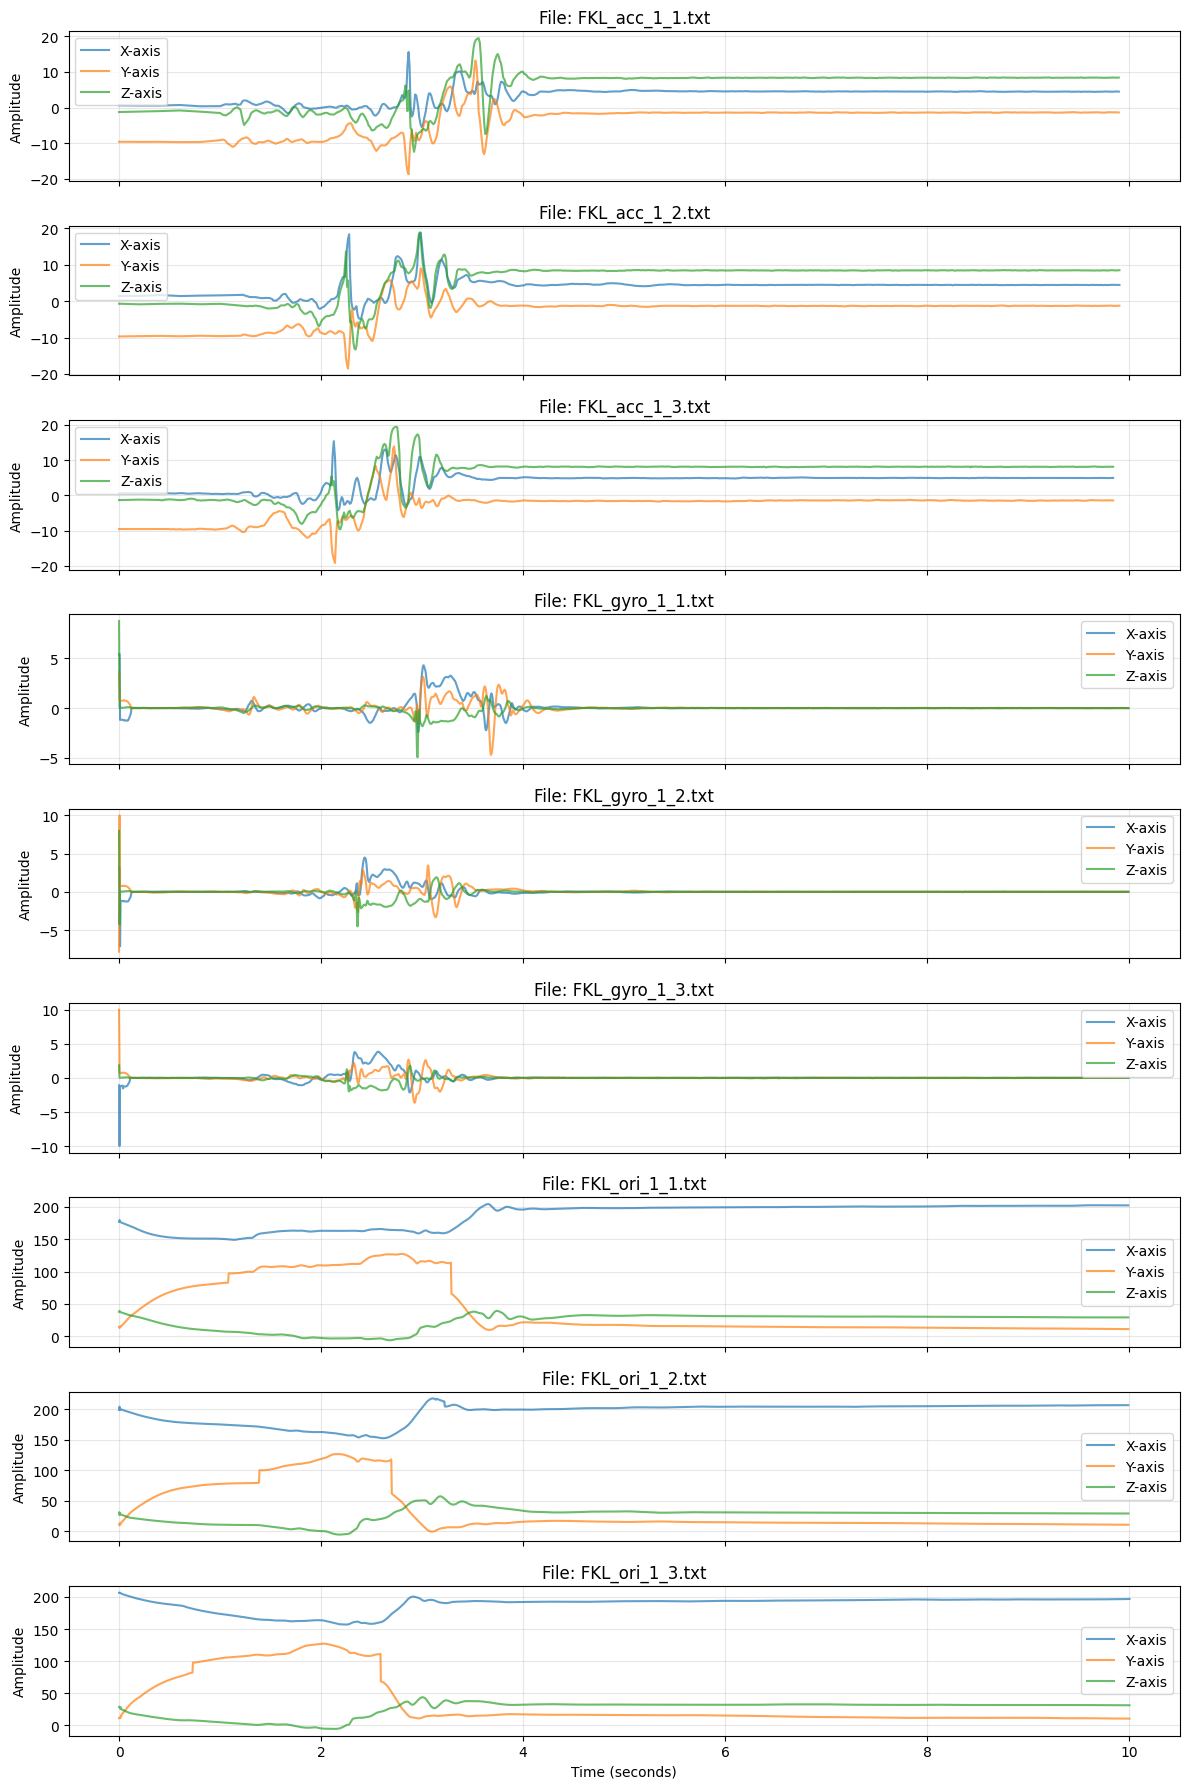

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

# Sub-directory for participant 1 falls - BSC
bsc_dir = os.path.join(base_dir, 'sub1', 'FALLS', 'FKL')

# Get all .txt files in the BSC directory
files = [f for f in os.listdir(bsc_dir) if f.endswith('.txt')]

# Create a subplot environment
num_files = len(files)
fig, axes = plt.subplots(num_files, 1, figsize=(12, 2 * num_files), sharex=True)

if num_files == 1:
    axes = [axes]  # To handle a single file case uniformly

for i, file in enumerate(files):
    # File path
    file_path = os.path.join(bsc_dir, file)
    
    # Reading the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Filtering and processing the data lines (ignore metadata and headers)
    data_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith("#") and not line.startswith("@"):
            data_lines.append(line.split(","))
    
    # Converting the filtered data into a DataFrame
    columns = ["timestamp(ns)", "x", "y", "z"]
    df = pd.DataFrame(data_lines, columns=columns, dtype=float)
    
    # Convert timestamp(ns) to seconds relative to the first timestamp
    df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

    # Plotting on the corresponding subplot
    axes[i].plot(df['time(s)'], df['x'], label="X-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['y'], label="Y-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['z'], label="Z-axis", alpha=0.7)
    axes[i].set_title(f"File: {file}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(alpha=0.3)
    if i == num_files - 1:  # Add xlabel only to the last subplot
        axes[i].set_xlabel("Time (seconds)")
    axes[i].legend()

plt.tight_layout()
plt.show()


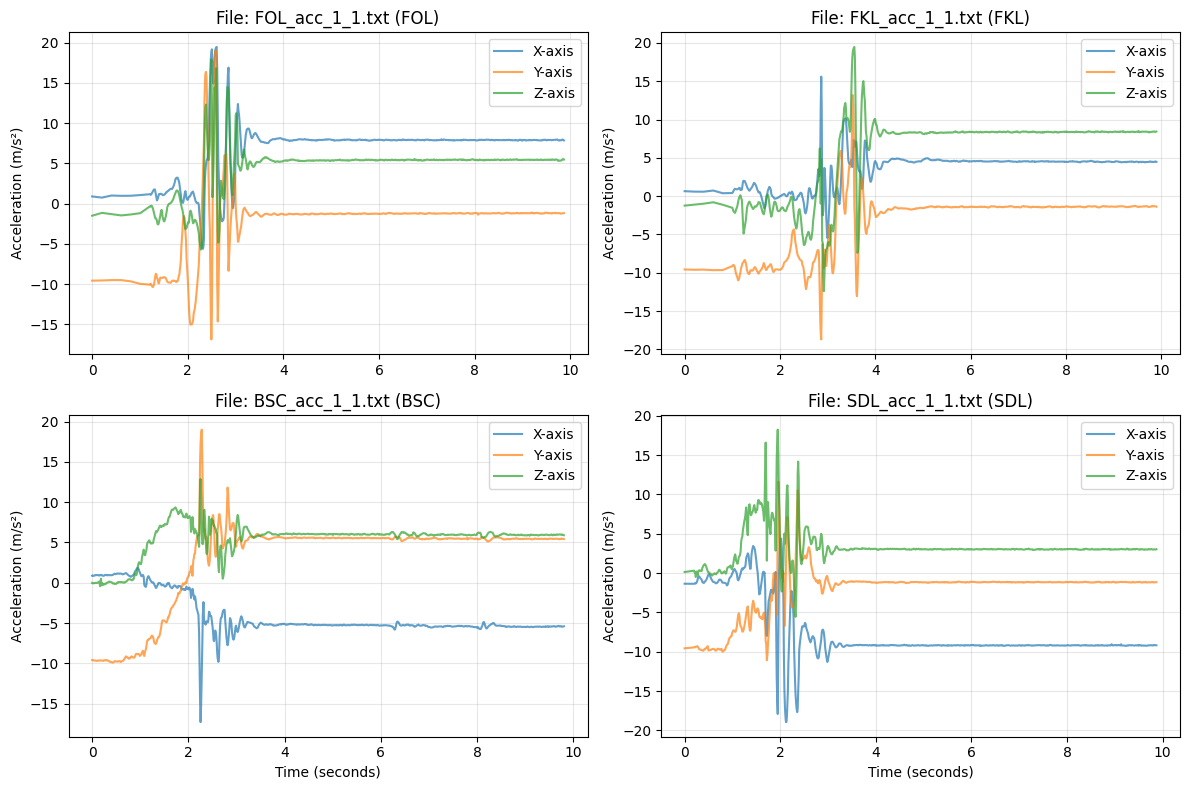

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

# Fall types and selected file pattern
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
selected_files = []

# Loop through each fall type and select one acceleration file (e.g., *_acc_1_1.txt)
for fall_type in fall_types:
    fall_dir = os.path.join(base_dir, 'sub1', 'FALLS', fall_type)
    files = [f for f in os.listdir(fall_dir) if f.endswith('_acc_1_1.txt')]
    if files:
        selected_files.append(os.path.join(fall_dir, files[0]))

# Create a 2x2 subplot environment
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each selected file
for i, file_path in enumerate(selected_files):
    # Reading the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Filtering and processing the data lines (ignore metadata and headers)
    data_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith("#") and not line.startswith("@"):
            data_lines.append(line.split(","))
    
    # Converting the filtered data into a DataFrame
    columns = ["timestamp(ns)", "x", "y", "z"]
    df = pd.DataFrame(data_lines, columns=columns, dtype=float)
    
    # Convert timestamp(ns) to seconds relative to the first timestamp
    df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

    # Plotting on the corresponding subplot
    axes[i].plot(df['time(s)'], df['x'], label="X-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['y'], label="Y-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['z'], label="Z-axis", alpha=0.7)
    axes[i].set_title(f"File: {os.path.basename(file_path)} ({fall_types[i]})")
    axes[i].set_ylabel("Acceleration (m/s²)")
    axes[i].grid(alpha=0.3)
    if i >= 2:  # Add xlabel only to the last row of subplots
        axes[i].set_xlabel("Time (seconds)")
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


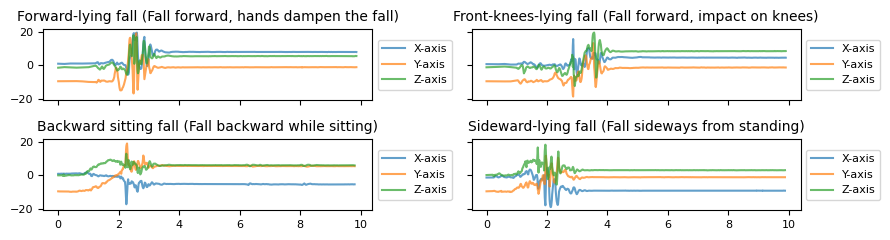

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing the dataset
base_dir = r'C:/Users/Teacher/Downloads/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main/MobiAct_Dataset_v2.0-MobiFall_Dataset_v2.0-main'

# Fall types and their descriptions
fall_types = [
    {"type": "FOL", "description": "Forward-lying fall (Fall forward, hands dampen the fall)"},
    {"type": "FKL", "description": "Front-knees-lying fall (Fall forward, impact on knees)"},
    {"type": "BSC", "description": "Backward sitting fall (Fall backward while sitting)"},
    {"type": "SDL", "description": "Sideward-lying fall (Fall sideways from standing)"}
]

selected_files = []

# Loop through each fall type and select one acceleration file (e.g., *_acc_1_1.txt)
for fall in fall_types:
    fall_dir = os.path.join(base_dir, 'sub1', 'FALLS', fall["type"])
    files = [f for f in os.listdir(fall_dir) if f.endswith('_acc_1_1.txt')]
    if files:
        selected_files.append({"file": os.path.join(fall_dir, files[0]), "description": fall["description"]})

# Create a 2x2 subplot environment
fig, axes = plt.subplots(2, 2, figsize=(9, 2.5), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each selected file
for i, item in enumerate(selected_files):
    file_path = item["file"]
    description = item["description"]
    
    # Reading the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Filtering and processing the data lines (ignore metadata and headers)
    data_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith("#") and not line.startswith("@"):
            data_lines.append(line.split(","))
    
    # Converting the filtered data into a DataFrame
    columns = ["timestamp(ns)", "x", "y", "z"]
    df = pd.DataFrame(data_lines, columns=columns, dtype=float)
    
    # Convert timestamp(ns) to seconds relative to the first timestamp
    df['time(s)'] = (df['timestamp(ns)'] - df['timestamp(ns)'].iloc[0]) / 1e9

    # Plotting on the corresponding subplot
    axes[i].plot(df['time(s)'], df['x'], label="X-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['y'], label="Y-axis", alpha=0.7)
    axes[i].plot(df['time(s)'], df['z'], label="Z-axis", alpha=0.7)
    axes[i].set_title(description, fontsize=10)
    axes[i].tick_params(labelsize=8)
    
    # Place the legend to the right of the plot
    axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
Epoch 1/50
43/43 [==============================] - 18s 218ms/step - loss: 0.4980 - accuracy: 0.7630 - val_loss: 0.3381 - val_accuracy: 0.8440
Epoch 2/50
43/43 [==============================] - 7s 162ms/step - loss: 0.2229 - accuracy: 0.9136 - val_loss: 0.2414 - val_accuracy: 0.9079
Epoch 3/50
43/43 [==============================] - 7s 164ms/step - loss: 0.1568 - accuracy: 0.9350 - val_loss: 0.1731 - val_accuracy: 0.9361
Epoch 4/50
43/43 [==============================] - 7s 164ms/step - loss: 0.1177 - accuracy: 0.9578 - val_loss: 0.1414 - val_accuracy: 0.9376
Epoch 5/50
43/43 [==============================] - 7s 169ms/step - loss: 0.0964 - accuracy: 0.9643 - val_loss: 0.1204 - val_accuracy: 0.9569
Epoch 6/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0911 - accuracy: 0.9645 - val_loss: 0.1016 - val_accuracy: 0.9629
Epoch 7/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0837 - accuracy: 0.9693 - val_loss: 0.0742 - val_accuracy: 0.9762
Epoch 8/50
43/43 [==============================] - 7s 162ms/step - loss: 0.0714 - accuracy: 0.9744 - val_loss: 0.0617 - val_accuracy: 0.9792
Epoch 9/50
43/43 [==============================] - 7s 175ms/step - loss: 0.0667 - accuracy: 0.9766 - val_loss: 0.0539 - val_accuracy: 0.9807
Epoch 10/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0650 - accuracy: 0.9788 - val_loss: 0.0517 - val_accuracy: 0.9807
Epoch 11/50
43/43 [==============================] - 7s 163ms/step - loss: 0.0628 - accuracy: 0.9777 - val_loss: 0.0488 - val_accuracy: 0.9807
Epoch 12/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0611 - accuracy: 0.9786 - val_loss: 0.0444 - val_accuracy: 0.9837
Epoch 13/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0551 - accuracy: 0.9816 - val_loss: 0.0441 - val_accuracy: 0.9837
Epoch 14/50
43/43 [==============================] - 7s 170ms/step - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.0421 - val_accuracy: 0.9896
Epoch 15/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0521 - accuracy: 0.9798 - val_loss: 0.0446 - val_accuracy: 0.9881
Epoch 16/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0508 - accuracy: 0.9796 - val_loss: 0.0453 - val_accuracy: 0.9896
Epoch 17/50
43/43 [==============================] - 7s 163ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 0.0454 - val_accuracy: 0.9896
Epoch 18/50
43/43 [==============================] - 7s 173ms/step - loss: 0.0488 - accuracy: 0.9831 - val_loss: 0.0480 - val_accuracy: 0.9881
Epoch 19/50
43/43 [==============================] - 7s 163ms/step - loss: 0.0416 - accuracy: 0.9853 - val_loss: 0.0475 - val_accuracy: 0.9881
Epoch 20/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0407 - accuracy: 0.9850 - val_loss: 0.0465 - val_accuracy: 0.9881
Epoch 21/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0429 - accuracy: 0.9874 - val_loss: 0.0441 - val_accuracy: 0.9881
Epoch 22/50
43/43 [==============================] - 7s 168ms/step - loss: 0.0412 - accuracy: 0.9855 - val_loss: 0.0453 - val_accuracy: 0.9881
Epoch 23/50
43/43 [==============================] - 7s 170ms/step - loss: 0.0363 - accuracy: 0.9879 - val_loss: 0.0454 - val_accuracy: 0.9881
Epoch 24/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0395 - accuracy: 0.9870 - val_loss: 0.0445 - val_accuracy: 0.9896
Epoch 25/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0397 - accuracy: 0.9883 - val_loss: 0.0450 - val_accuracy: 0.9896
Epoch 26/50
43/43 [==============================] - 7s 167ms/step - loss: 0.0346 - accuracy: 0.9892 - val_loss: 0.0439 - val_accuracy: 0.9896
Epoch 27/50
43/43 [==============================] - 7s 173ms/step - loss: 0.0346 - accuracy: 0.9879 - val_loss: 0.0466 - val_accuracy: 0.9896
Epoch 28/50
43/43 [==============================] - 7s 163ms/step - loss: 0.0321 - accuracy: 0.9889 - val_loss: 0.0510 - val_accuracy: 0.9851
Epoch 29/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0355 - accuracy: 0.9898 - val_loss: 0.0467 - val_accuracy: 0.9866
Epoch 30/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0346 - accuracy: 0.9885 - val_loss: 0.0457 - val_accuracy: 0.9866
Epoch 31/50
43/43 [==============================] - 7s 172ms/step - loss: 0.0350 - accuracy: 0.9894 - val_loss: 0.0454 - val_accuracy: 0.9881
Epoch 32/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0319 - accuracy: 0.9892 - val_loss: 0.0467 - val_accuracy: 0.9881
Epoch 33/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0349 - accuracy: 0.9892 - val_loss: 0.0459 - val_accuracy: 0.9881
Epoch 34/50
43/43 [==============================] - 7s 163ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.0446 - val_accuracy: 0.9881
Epoch 35/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0449 - val_accuracy: 0.9881
Epoch 36/50
43/43 [==============================] - 7s 172ms/step - loss: 0.0359 - accuracy: 0.9909 - val_loss: 0.0455 - val_accuracy: 0.9881
Epoch 37/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0294 - accuracy: 0.9903 - val_loss: 0.0458 - val_accuracy: 0.9881
Epoch 38/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.0460 - val_accuracy: 0.9881
Epoch 39/50
43/43 [==============================] - 7s 163ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.0467 - val_accuracy: 0.9881
Epoch 40/50
43/43 [==============================] - 8s 176ms/step - loss: 0.0305 - accuracy: 0.9896 - val_loss: 0.0476 - val_accuracy: 0.9881
Epoch 41/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.0472 - val_accuracy: 0.9881
Epoch 42/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.0467 - val_accuracy: 0.9881
Epoch 43/50
43/43 [==============================] - 7s 167ms/step - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.0463 - val_accuracy: 0.9881
Epoch 44/50
43/43 [==============================] - 7s 171ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0460 - val_accuracy: 0.9881
Epoch 45/50
43/43 [==============================] - 7s 166ms/step - loss: 0.0270 - accuracy: 0.9920 - val_loss: 0.0459 - val_accuracy: 0.9881
Epoch 46/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0298 - accuracy: 0.9903 - val_loss: 0.0464 - val_accuracy: 0.9881
Epoch 47/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.0443 - val_accuracy: 0.9896
Epoch 48/50
43/43 [==============================] - 7s 164ms/step - loss: 0.0316 - accuracy: 0.9915 - val_loss: 0.0440 - val_accuracy: 0.9896
Epoch 49/50
43/43 [==============================] - 7s 175ms/step - loss: 0.0259 - accuracy: 0.9926 - val_loss: 0.0444 - val_accuracy: 0.9896
Epoch 50/50
43/43 [==============================] - 7s 165ms/step - loss: 0.0276 - accuracy: 0.9905 - val_loss: 0.0446 - val_accuracy: 0.9896


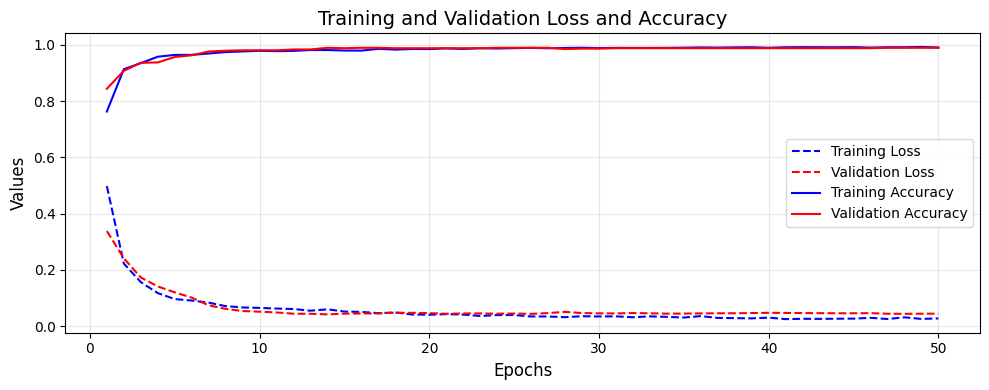

In [20]:
import matplotlib.pyplot as plt

# Extracted data
epochs = list(range(1, 51))
train_loss = [0.4980, 0.2229, 0.1568, 0.1177, 0.0964, 0.0911, 0.0837, 0.0714, 0.0667, 0.0650,
              0.0628, 0.0611, 0.0551, 0.0600, 0.0521, 0.0508, 0.0464, 0.0488, 0.0416, 0.0407,
              0.0429, 0.0412, 0.0363, 0.0395, 0.0397, 0.0346, 0.0346, 0.0321, 0.0355, 0.0346,
              0.0350, 0.0319, 0.0349, 0.0332, 0.0308, 0.0359, 0.0294, 0.0287, 0.0278, 0.0305,
              0.0252, 0.0263, 0.0261, 0.0266, 0.0270, 0.0298, 0.0256, 0.0316, 0.0259, 0.0276]
train_accuracy = [0.7630, 0.9136, 0.9350, 0.9578, 0.9643, 0.9645, 0.9693, 0.9744, 0.9766, 0.9788,
                  0.9777, 0.9786, 0.9816, 0.9816, 0.9798, 0.9796, 0.9859, 0.9831, 0.9853, 0.9850,
                  0.9874, 0.9855, 0.9879, 0.9870, 0.9883, 0.9892, 0.9879, 0.9889, 0.9898, 0.9885,
                  0.9894, 0.9892, 0.9892, 0.9894, 0.9900, 0.9909, 0.9903, 0.9911, 0.9915, 0.9896,
                  0.9915, 0.9918, 0.9916, 0.9915, 0.9920, 0.9903, 0.9915, 0.9915, 0.9926, 0.9905]
val_loss = [0.3381, 0.2414, 0.1731, 0.1414, 0.1204, 0.1016, 0.0742, 0.0617, 0.0539, 0.0517,
            0.0488, 0.0444, 0.0441, 0.0421, 0.0446, 0.0453, 0.0454, 0.0480, 0.0475, 0.0465,
            0.0441, 0.0453, 0.0454, 0.0445, 0.0450, 0.0439, 0.0466, 0.0510, 0.0467, 0.0457,
            0.0454, 0.0467, 0.0459, 0.0446, 0.0449, 0.0455, 0.0458, 0.0460, 0.0467, 0.0476,
            0.0472, 0.0467, 0.0463, 0.0460, 0.0459, 0.0464, 0.0443, 0.0440, 0.0444, 0.0446]
val_accuracy = [0.8440, 0.9079, 0.9361, 0.9376, 0.9569, 0.9629, 0.9762, 0.9792, 0.9807, 0.9807,
                0.9807, 0.9837, 0.9837, 0.9896, 0.9881, 0.9896, 0.9896, 0.9881, 0.9881, 0.9881,
                0.9881, 0.9881, 0.9881, 0.9896, 0.9896, 0.9896, 0.9896, 0.9851, 0.9866, 0.9866,
                0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9881,
                0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9881, 0.9896, 0.9896, 0.9896, 0.9896]


# Plotting training and validation loss and accuracy in one chart
plt.figure(figsize=(10, 4))

# Plot training and validation loss
plt.plot(epochs, train_loss, label="Training Loss", color="blue", linestyle='--')
plt.plot(epochs, val_loss, label="Validation Loss", color="red", linestyle='--')

# Plot training and validation accuracy
plt.plot(epochs, train_accuracy, label="Training Accuracy", color="blue")
plt.plot(epochs, val_accuracy, label="Validation Accuracy", color="red")

# Adding labels, title, legend, and grid
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Training and Validation Loss and Accuracy", fontsize=14)
plt.legend(fontsize=10, loc="center right")
plt.grid(alpha=0.3)
plt.tight_layout()

# Display the chart
plt.show()




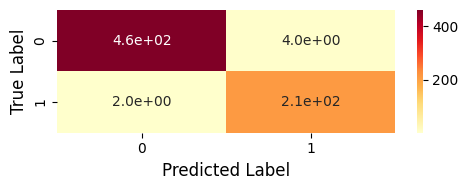

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example confusion matrix data
confusion_matrix_data = np.array([[460, 4], [2, 210]])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5, 2))
sns.heatmap(confusion_matrix_data, annot=True, fmt=".1e", cmap="YlOrRd", cbar=True,  linecolor='black')
# plt.title("Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

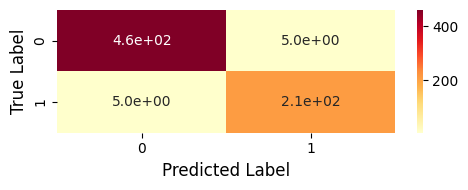

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example confusion matrix data
confusion_matrix_data = np.array([[460, 5], [5, 210]])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5, 2))
sns.heatmap(confusion_matrix_data, annot=True, fmt=".1e", cmap="YlOrRd", cbar=True,  linecolor='black')
# plt.title("Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


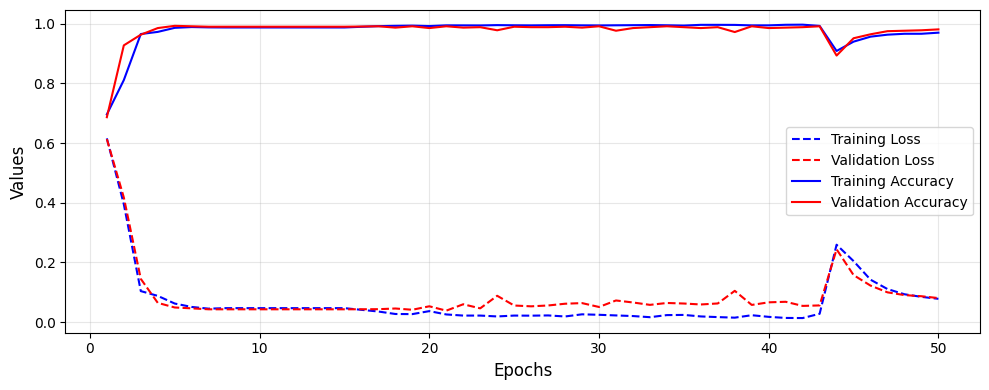

In [27]:
import matplotlib.pyplot as plt

# Data extracted from the provided logs
epochs = list(range(1, 51))
train_loss = [
    0.6156, 0.3947, 0.1039, 0.0879, 0.0622, 0.0508, 0.0451, 0.0468, None, None, None, None, None, None, None, None, 0.0355, 0.0272, 0.0268, 0.0368,
    0.0257, 0.0219, 0.0219, 0.0190, 0.0219, 0.0216, 0.0224, 0.0189, 0.0261, 0.0245, 0.0224, 0.0203, 0.0165, 0.0235, 0.0241, 0.0190, 0.0168, 0.0149, 
    0.0231, 0.0176, 0.0140, 0.0136, 0.0279, 0.2593, 0.2044, 0.1421, 0.1107, 0.0933, 0.0846, 0.0780
]
train_accuracy = [
    0.6959, 0.8109, 0.9651, 0.9723, 0.9859, 0.9885, 0.9874, 0.9871, None, None, None, None, None, None, None, None, 0.9916, 0.9926, 0.9933, 0.9918,
    0.9942, 0.9941, 0.9939, 0.9950, 0.9944, 0.9941, 0.9946, 0.9948, 0.9942, 0.9939, 0.9944, 0.9948, 0.9952, 0.9944, 0.9935, 0.9959, 0.9959, 0.9957, 
    0.9941, 0.9942, 0.9961, 0.9965, 0.9924, 0.9084, 0.9396, 0.9563, 0.9630, 0.9660, 0.9660, 0.9697
]
val_loss = [
    0.6132, 0.4175, 0.1448, 0.0645, 0.0490, 0.0461, 0.0429, None, None, None, None, None, None, None, None, None, 0.0433, 0.0456, 0.0414, 0.0530,
    0.0384, 0.0598, 0.0461, 0.0882, 0.0556, 0.0529, 0.0557, 0.0616, 0.0637, 0.0507, 0.0725, 0.0658, 0.0578, 0.0641, 0.0623, 0.0591, 0.0625, 0.1048,
    0.0576, 0.0663, 0.0681, 0.0543, 0.0559, 0.2439, 0.1575, 0.1223, 0.0997, 0.0905, 0.0867, 0.0805
]
val_accuracy = [
    0.6865, 0.9272, 0.9629, 0.9851, 0.9926, 0.9911, 0.9896, None, None, None, None, None, None, None, None, None, 0.9911, 0.9866, 0.9911, 0.9851,
    0.9911, 0.9866, 0.9881, 0.9777, 0.9896, 0.9881, 0.9881, 0.9896, 0.9866, 0.9911, 0.9762, 0.9851, 0.9881, 0.9911, 0.9881, 0.9851, 0.9881, 0.9718,
    0.9911, 0.9851, 0.9866, 0.9881, 0.9911, 0.8930, 0.9510, 0.9643, 0.9747, 0.9762, 0.9777, 0.9807
]




def replace_nan_with_avg(data):
    data = np.array(data, dtype=float)  # Convert to NumPy array for easier processing
    for i in range(len(data)):
        if np.isnan(data[i]):  # Check if the value is NaN
            neighbors = [data[i - 1] if i - 1 >= 0 else 0, data[i + 1] if i + 1 < len(data) else 0]
            data[i] = np.mean([n for n in neighbors if not np.isnan(n)])  # Replace with average of neighbors
    return data.tolist()

# Replace None values
train_loss = replace_nan_with_avg([val if val is not None else np.nan for val in train_loss])
train_accuracy = replace_nan_with_avg([val if val is not None else np.nan for val in train_accuracy])
val_loss = replace_nan_with_avg([val if val is not None else np.nan for val in val_loss])
val_accuracy = replace_nan_with_avg([val if val is not None else np.nan for val in val_accuracy])

# Plotting loss and accuracy on the same chart after replacing NaNs
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, label="Training Loss", color="blue", linestyle="--")
plt.plot(epochs, val_loss, label="Validation Loss", color="red", linestyle="--")
plt.plot(epochs, train_accuracy, label="Training Accuracy", color="blue")
plt.plot(epochs, val_accuracy, label="Validation Accuracy", color="red")

# Chart details
# plt.title("Training and Validation Loss and Accuracy (NaNs Replaced with Averages)", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(loc="center right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Display chart
plt.show()


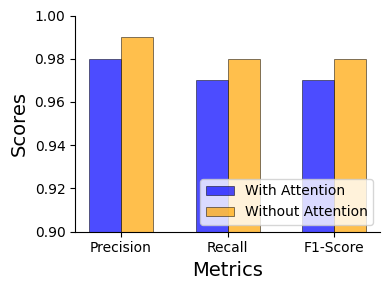

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Data for "with attention" and "without attention"
categories = ["Precision", "Recall", "F1-Score"]
with_attention = [0.98, 0.97, 0.97]
without_attention = [0.99, 0.98, 0.98]

x = np.arange(len(categories))  # X positions for categories
bar_width = 0.3  # Width of the bars

# Creating the figure
plt.figure(figsize=(4, 3))

# Plotting bars for "With Attention"
plt.bar(x - bar_width / 2, with_attention, bar_width, label="With Attention", color="blue", alpha=0.7, linewidth=0.5, edgecolor='black')

# Plotting bars for "Without Attention"
plt.bar(x + bar_width / 2, without_attention, bar_width, label="Without Attention", color="orange", alpha=0.7, linewidth=0.5, edgecolor='black')

# Adding labels, titles, and legend
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Scores", fontsize=14)
# plt.title("Performance Comparison: With vs. Without Attention", fontsize=16)
plt.xticks(x, categories)
plt.legend(fontsize=10, loc='lower right')

# Removing grid and customizing borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting y-axis limit
plt.ylim(0.9, 1.0)

# Tight layout for a clean look
plt.tight_layout()

# Display the chart
plt.show()
